In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "mango_class/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/mango_class


In [ ]:
import torch
USE_GPU = True

# dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)



using device: cuda


In [ ]:
import os
import cv2
from PIL import Image#https://yungyuc.github.io/oldtech/python/python_imaging.html
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import numpy as np
from PIL import Image#https://yungyuc.github.io/oldtech/python/python_imaging.html




In [ ]:
from py_files.dataloader2 import *
# import random as rd

In [ ]:
i = 2
# preprocess_img(i, '/C1-P1_Train_Dev_fixed/C1-P1_Train/batch' + str(i))

In [ ]:
#in this cell, you can check if you had already finished preprocessing
#if ok: it will show 800
#else: it will show 0
# path = './C1-P1_Train_Dev_fixed/C1-P1_Train/batch' + str(i)
# path2 = path.replace("Train/","Train_after/")
# train_after_files = os.listdir(path2)
# print(len(train_after_files))

In [ ]:
NUM_TRAIN = 1300
dataloaders = {"train":None, "dev":None}
dataset_sizes = {"train":None,"dev":None}
dataset = mango(
    pic_root='/C1-P1_Train_Dev_fixed_nobatch/C1-P1_Train/batch' + str(i),
    label_root = '/C1-P1_Train_Dev_fixed_nobatch/train.csv',
    preload=True,
    phase = "train",
)#把traning的dataset載下來
# batch_size =128

# trainset_loader = DataLoader(trainset, batch_size=batch_size
#                             , shuffle=True, num_workers=4)
trainset_loader = DataLoader(dataset, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# dataset.phase = "dev"
devset_loader = DataLoader(dataset, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 1400)))



In [ ]:
# devset = mango(
#     pic_root='/C1-P1_Train_Dev_fixed/C1-P1_Dev',
#     label_root = '/C1-P1_Train_Dev_fixed/dev.csv',
#     preload=True,
#     phase = "dev",
# )#把dev的dataset載下來

# devset_loader = DataLoader(devset, batch_size=batch_size
#                             , shuffle=True, num_workers=4)
# # Use the torch dataloader to iterate through the dataset

dataloaders.update(train = trainset_loader)
dataloaders.update(dev = devset_loader)
dataset_sizes.update(train = len(trainset_loader))
dataset_sizes.update(dev = len(devset_loader))


In [ ]:
path = './C1-P1_Train_Dev_fixed_nobatch/C1-P1_Train/batch' + str(i)
# path2 = path.replace("Train/","Train_after/")
train_files = os.listdir(path)
print(len(train_files))

1400


In [ ]:

# Use the torch dataloader to iterate through the dataset



In [ ]:
dataset_sizes["train"]
# devset_loader = DataLoader(devset, batch_size=800, shuffle=True, num_workers=1)
# Use the torch dataloader to iterate through the dataset

11

### Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


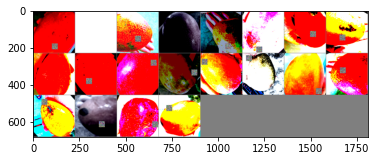

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


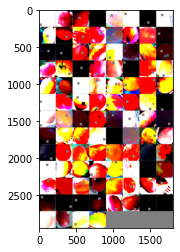

In [ ]:
#這樣試看看
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = None
labels = None
# get some random training images
for images, labels in trainset_loader:
  images = images
  labels = labels

# print(type(train_images))
# show images
imshow(torchvision.utils.make_grid(images))
print("=======================================")
for images, labels in devset_loader:
  images = images
  labels = labels
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
# from sklearn.svm import LinearSVC as svm
# from sklearn.model_selection import cross_validate
from sklearn.externals import joblib
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:

model = models.vgg11(pretrained=True)
model = model.features[0:39]

for param in model.parameters():
    param.requires_grad = False
# model[0][0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.fc = nn.Sequential(
   
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    # nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.AdaptiveAvgPool2d(output_size=(7, 7)),

    nn.Flatten(),
    # nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),

    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=4096, out_features=3, bias=True),

    )
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# 只优化最后的分类层
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
# optimizer_ft = optim.Adam(model.fc.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = torch.tensor(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                # print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              train_acc = epoch_acc

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc and train_acc - epoch_acc < 5:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best dev Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train Loss: 130.1160 Acc: 42.0909
dev Loss: 108.2346 Acc: 38.0000

Epoch 1/24
----------
train Loss: 130.7890 Acc: 43.2727
dev Loss: 105.8440 Acc: 47.0000

Epoch 2/24
----------
train Loss: 127.7689 Acc: 51.2727
dev Loss: 103.0108 Acc: 49.0000

Epoch 3/24
----------
train Loss: 115.3311 Acc: 58.4545
dev Loss: 89.4407 Acc: 58.0000

Epoch 4/24
----------
train Loss: 107.9950 Acc: 63.9091
dev Loss: 87.4168 Acc: 59.0000

Epoch 5/24
----------
train Loss: 102.8638 Acc: 68.5455
dev Loss: 88.0054 Acc: 58.0000

Epoch 6/24
----------
train Loss: 101.0671 Acc: 67.3636
dev Loss: 85.1023 Acc: 62.0000

Epoch 7/24
----------
train Loss: 98.3541 Acc: 70.5455
dev Loss: 78.4818 Acc: 64.0000

Epoch 8/24
----------
train Loss: 97.7975 Acc: 69.9091
dev Loss: 85.0674 Acc: 58.0000

Epoch 9/24
----------


KeyboardInterrupt: ignored

In [ ]:
ji3g4


In [ ]:
for inputs, labels in dataloaders["train"]:
  print(inputs.size())

torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([20, 3, 224, 224])


In [ ]:
for pa in model.fc.parameters():
  pa = pa.requires_grad
  print(pa)

True
True
True
True
True
True
True
True


In [ ]:
# #save the model
# state = {'svm_model': model}
# torch.save(state, "model_params/batch" + str(i) + "_svm_model.pth")
# # torch.save(model, "model_params/resnet18.pth")

In [ ]:
torch.save(model.fc.state_dict(), "model_params/nobatch" + str(i) + "_vgg16_try.pth")
# torch.save(optimizer_ft.state_dict(), "optimizer_params/nobatch" + str(i) + "_vgg16.pth")
# torch.save(exp_lr_scheduler.state_dict(), "exp_lr_scheduler_params/nobatch" + str(i) + "_vgg16.pth")